# Analysis of contigs mapped to viral CDDs


We used contigs assemnbled using SKESA from ~3000 SRR metagenomes. These metagenomes were selected based on its viral content. See [here](https://github.com/NCBI-Hackathons/VirusDiscoveryProject/tree/master/DataSelection) for details on how these metagenomes were selected. Thesse contigs were then used as queries to search using RPSTBLASTN against CDD database that had been filtered to only have viral specific CDDs. These list were also generated in previous hackathon. See [here](https://github.com/NCBI-Hackathons/VirusDiscoveryProject/tree/master/DomainLabeling/RPSTBLN/CDDlabels) for the list the ids. 

In [1]:
# importing relvant python packages
import pandas as pd
import seaborn as sns
import sklearn.decomposition
import matplotlib.pyplot as plt

Read in the rps blast result dataframe and parse information on contig lengths

In [2]:
rps_cdd_df = pd.read_csv("cdd_data_forindex_original.tsv", sep="\t", index_col=0)
rps_cdd_df[['contig_id_only','start_end']] = rps_cdd_df['contig_id'].str.split(":", expand=True) 
rps_cdd_df[['cstart', 'contig_length']] = rps_cdd_df['start_end'].str.split(".", expand=True)
rps_cdd_df = rps_cdd_df.drop(['start_end', 'cstart'], axis=1)
rps_cdd_df.head()


/opt/tljh/user/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,contig_id,CDD,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,SRR,contig_id_only,contig_length
0,Contig_262_136.931:1.131564,CDD:280594,30.769,78,42,3,7338,7111,66,133,1.170000e-04,41.0,SRR4451607,Contig_262_136.931,131564
1,Contig_321_123.726:1.12237,CDD:222861,38.528,231,131,3,5068,5739,1,227,1.040000e-47,162.0,SRR4451607,Contig_321_123.726,12237
2,Contig_325_135.454:1.51712,CDD:222804,26.087,69,50,1,31540,31337,94,162,2.680000e-04,38.3,SRR4451607,Contig_325_135.454,51712
3,NC_019445.1_3:1.15349,CDD:283078,91.379,58,5,0,14004,14177,1,58,3.460000e-27,97.9,SRR4451607,NC_019445.1_3,15349
4,Contig_17_145.65:1.11778,CDD:165469,47.489,219,106,4,9292,8645,99,311,6.620000e-73,238.0,SRR4451607,Contig_17_145.65,11778


In [3]:
# getting the table with number of CDD hits per contig
cdd_percontig = pd.DataFrame(rps_cdd_df.groupby(by='contig_id').size())
cdd_percontig = cdd_percontig.rename(columns={0:"cdd_per_contigs"})
cdd_percontig.head()


,cdd_per_contigs
contig_id,
AB126192.2:1.2363,4
AB126195.1:1.1807,1
AF086833.2:1.18959,39
AF144300.1:1.2341,1
AF144301.1:1.2341,3


In [4]:
# Number of contigs that were processed
cdd_percontig.shape

(5606754, 1)

In [5]:
# Top 10 contig with highest hit
cdd_percontig.sort_values(['cdd_per_contigs'], ascending=False).head(n=10)

,cdd_per_contigs
contig_id,
NC_003663.2:1.224499,36768
NC_006560.1:1.150715,26448
NC_003310.1:1.196858,21168
NC_001716.2:1.153080,9632
NC_005336.1:1.139962,7968
NC_001798.2:1.154675,6993
NC_001806.2:1.152222,6955
NC_001664.3:1.159321,6815
NC_001611.1:1.185578,6270


In [6]:
# adding a column with density of CDD per 1Kb

# generating a separate table
rps_cdd_df_index = rps_cdd_df
# converting a column to index
rps_cdd_df_index.index = rps_cdd_df['contig_id']
rps_cdd_df_index = rps_cdd_df_index.drop(columns=["contig_id"])
rps_cdd_df_density = rps_cdd_df_index.merge(cdd_percontig, how="left", left_index=True, right_index=True)
rps_cdd_df_density['contig_length'] = rps_cdd_df_density['contig_length'].astype(int)
rps_cdd_df_density['cdd_per_contigs'] = rps_cdd_df_density['cdd_per_contigs'].astype(int)
rps_cdd_df_density['cdd_per_kb'] = (rps_cdd_df_density['cdd_per_contigs']/rps_cdd_df_density['contig_length'])*1000
rps_cdd_df_density.head()

,CDD,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore,SRR,contig_id_only,contig_length,cdd_per_contigs,cdd_per_kb
contig_id,,,,,,,,,,,,,,,,
AB126192.2:1.2363,CDD:278997,68.114,737,230,3,18,2228,1,732,0.000000e+00,1232.0,ERR1121418,AB126192.2,2363,4,1.692763
AB126192.2:1.2363,CDD:282102,17.718,333,221,14,780,1676,373,686,1.970000e-09,50.9,ERR1121418,AB126192.2,2363,4,1.692763
AB126192.2:1.2363,CDD:278997,68.114,737,230,3,18,2228,1,732,0.000000e+00,1232.0,SRR5940707,AB126192.2,2363,4,1.692763
AB126192.2:1.2363,CDD:282102,17.718,333,221,14,780,1676,373,686,1.970000e-09,50.9,SRR5940707,AB126192.2,2363,4,1.692763
AB126195.1:1.1807,CDD:278907,23.301,515,354,16,39,1547,28,513,2.720000e-32,121.0,ERR1121418,AB126195.1,1807,1,0.553403


Distribution of number of CDD per 1 KB

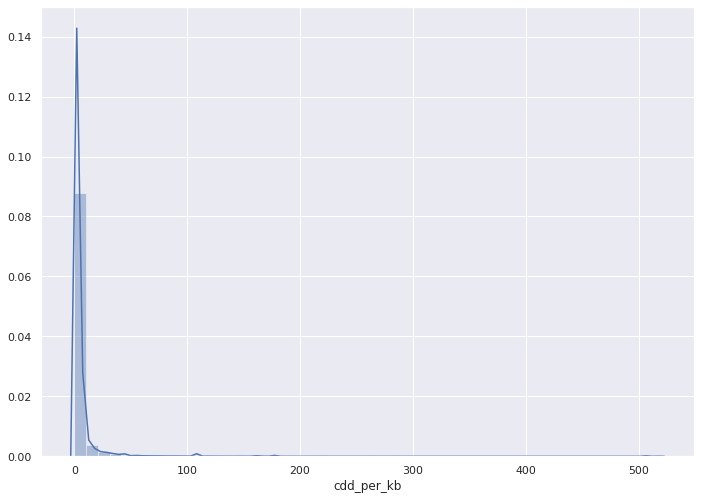

In [14]:
# plt_dist_den = rps_cdd_df_density['cdd_per_kb'].plot.hist(bins=25, log=True)
# plt_dist_den.set_xlabel("CDD per 1 KB")
# plt_dist_den
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(rps_cdd_df_density['cdd_per_kb'])

In [8]:
# count the number of CDDs per SRR ids
srr_cdd_df = rps_cdd_df_density[["CDD", "SRR"]]
srr_cdd_df.head()
srr_cdd_count = srr_cdd_df.groupby(['SRR', 'CDD']).size()
srr_cdd_count.head()

SRR        CDD       
DRR019508  CDD:106901     1
           CDD:106954     3
           CDD:106959     1
           CDD:106962     2
           CDD:106966    15
dtype: int64

In [10]:
# pivot the table to sample as index and then CDD ids as coumn header
srr_cdd_table = pd.DataFrame(srr_cdd_count).reset_index()

srr_cdd_pivot_table = srr_cdd_table.pivot(index="SRR", columns="CDD", values=0).fillna(0)
srr_cdd_pivot_table.head()

CDD,CDD:106880,CDD:106886,CDD:106901,CDD:106954,CDD:106959,CDD:106962,CDD:106963,CDD:106964,CDD:106966,CDD:106967,...,CDD:337153,CDD:337290,CDD:337301,CDD:337327,CDD:337835,CDD:337865,CDD:70500,CDD:72144,CDD:72147,CDD:72614
SRR,,,,,,,,,,,,,,,,,,,,,
DRR019508,0.0,0.0,1.0,3.0,1.0,2.0,0.0,0.0,15.0,7.0,...,0.0,0.0,0.0,7.0,0.0,1.0,0.0,1.0,0.0,0.0
DRR027576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DRR027577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
DRR027588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0
DRR042075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


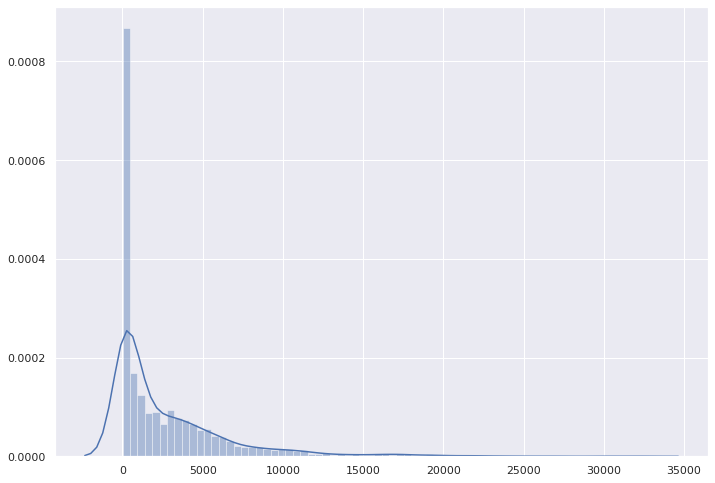

In [29]:
# distribution of number of CDDs per sample
sns.distplot(srr_cdd_pivot_table.sum(axis=1), bins=70)

# sns.clustermap(srr_cdd_pivot_table)

In [33]:
# Top 25 SRR with most CDD hits( not unique CDD hits)
srr_cdd_pivot_table.sum(axis=1).sort_values(ascending=False).head(n=25)

SRR
ERR1823512    32291.0
ERR2726432    30317.0
SRR5678966    26792.0
ERR2227809    25101.0
SRR5115412    23780.0
ERR1539547    23520.0
ERR982823     22381.0
ERR1879297    22107.0
SRR7686842    22037.0
SRR5813532    21883.0
SRR6747737    21371.0
ERR1539472    21130.0
SRR6323390    20760.0
ERR1711665    20412.0
ERR1711796    20145.0
SRR2910722    19586.0
ERR209830     19462.0
SRR6041132    19451.0
ERR260259     19342.0
SRR3479770    19324.0
ERR675589     19313.0
ERR1539670    19085.0
SRR5813404    18915.0
ERR247160     18465.0
SRR5650164    18440.0
dtype: float64

In [41]:
srr_cdd_pivot_table[srr_cdd_pivot_table.sum(axis = 1) > 1]
filtered_srr_cds = srr_cdd_pivot_table[srr_cdd_pivot_table.sum(axis = 1) > 1]

In [43]:
# Perform the PCA again retaining only the top 2 components
sklearn_pca = sklearn.decomposition.PCA(n_components=2)


sklearn_pca.fit(filtered_srr_cds)

# # Project the data into this 2D space and convert it back to a tidy dataframe
df_2D = pd.DataFrame(sklearn_pca.transform(filtered_srr_cds),
                      columns=['PCA1', 'PCA2'])

# # Create a column for species name
df_2D['SRR'] = filtered_srr_cds.index

# # Look at the result
df_2D.head()

,PCA1,PCA2,SRR
0,4.789478,227.149189,DRR019508
1,-285.615686,-50.535943,DRR027576
2,-278.325727,-49.349589,DRR027577
3,-185.286257,-31.136539,DRR027588
4,-298.621725,-71.511030,DRR042075


No handles with labels found to put in legend.


Text(0, 0.5, 'PCA 2')

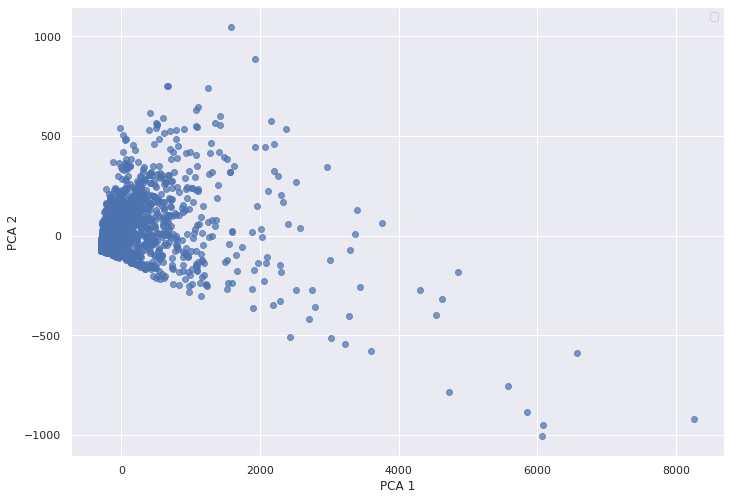

In [44]:


# Tidy up plot
plt.plot(df_2D.PCA1, df_2D.PCA2, 'o', alpha=0.7)
plt.legend(loc=0)
plt.margins(0.05)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [13]:
a.groupby(['SRR', 'CDD']).apply(int).to_dic()

TypeError: int() argument must be a string, a bytes-like object or a number, not 'DataFrame'

In [ ]:
df_ = pd.DataFrame(index=set(a["SRR"].tolist()), columns=[a["CDD"].tolist()]).transpose()
df_.head()

In [ ]:
pd.DataFrame(df.groupby(['SRR']).count().sort_values(['CDD'], ascending=False)).iloc[:,1]

Most CDD hits in SRR5678966

In [ ]:
df[df['SRR'] == "SRR5678966"].groupby("CDD").count().sort_values('contig_id', ascending=False).iloc[:,1]

In [ ]:
df_cddcount_.iloc()

Plots of distribution of scores

In [ ]:
df['pident'].plot.hist(bins=25)

In [ ]:
df.groupby("contig_id").count().sort_values(["CDD"], ascending=False)

Distribution of number of domain per contigs

In [ ]:
df.groupby("contig_id").count()['CDD'].plot.hist(range=(0,20000), log=True)

In [ ]:
contig_df = df[df.contig_id.str.contains('^Contig_')]
contig_df.head()

In [ ]:
contig_df.groupby("contig_id").count().sort_values(["CDD"], ascending=False)['pident'].plot.hist(range=(0,250),log=True)